# Deep Dive: Advanced Neuron Querying

This tutorial explores the powerful and flexible querying capabilities of CRANTpy. We'll go beyond simple filters and dive into:

1.  **Complex, multi-parameter queries**
2.  **Using regular expressions** for flexible matching
3.  **Inspecting available data** to build your queries
4.  **Analyzing populations** of neurons returned from queries

Let's get started by setting up our environment.

In [1]:
# Import CRANTpy and other necessary libraries
import crantpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging to see progress
cp.set_logging_level("WARNING")  # Quieter for this tutorial

print("CRANTpy loaded successfully!")
print(f"Default dataset: {cp.CRANT_DEFAULT_DATASET}")

CRANTpy loaded successfully!
Default dataset: latest


## 1. Authentication Setup

First, ensure you are authenticated with the CAVE service.

In [2]:
# Generate and save authentication token (uncomment if first time)
# cp.generate_cave_token(save=True)

# Test connection
try:
    client = cp.get_cave_client()
    print(f"Successfully connected to datastack: {client.datastack_name}")
    print(f"Server: {client.server_address}")
except Exception as e:
    print(f"Connection failed: {e}")
    print("Please run: cp.generate_cave_token(save=True)")

Successfully connected to datastack: kronauer_ant
Server: https://proofreading.zetta.ai


## 2. Exploring Available Annotation Data

To build powerful queries, you first need to know what data you can filter on. Let's inspect the available annotation fields and their values.

In [3]:
# Get all available annotation fields
available_fields = cp.NeuronCriteria.available_fields()
print(f"Available annotation fields ({len(available_fields)}):")
for field in sorted(available_fields):
    print(f"  - {field}")

Available annotation fields (25):
  - alternative_names
  - annotator_notes
  - cave_table
  - cell_class
  - cell_instance
  - cell_subtype
  - cell_type
  - date_proofread
  - flow
  - hemilineage
  - known_nt
  - known_nt_source
  - nerve
  - ngl_link
  - nucleus_id
  - proofread
  - proofreader_notes
  - region
  - root_id
  - side
  - status
  - super_class
  - tract
  - user_annotator
  - user_proofreader


In [4]:
# Get an overview of the entire dataset annotations
all_annotations = cp.get_all_seatable_annotations()
print(f"Total neurons in dataset: {len(all_annotations):,}")
print(f"Dataset shape: {all_annotations.shape}")
print("\nFirst few rows:")
display(all_annotations.head())

Total neurons in dataset: 6,166
Dataset shape: (6166, 30)

First few rows:


,root_id,root_id_processed,supervoxel_id,position,nucleus_id,nucleus_position,root_position,cave_table,proofread,status,...,cell_subtype,cell_instance,known_nt,known_nt_source,alternative_names,annotator_notes,user_annotator,user_proofreader,ngl_link,date_proofread
0,576460752700282748,None,74170512125421134,"[32782, 30214, 1532]",72691394107456688,"[37306, 31317, 1405]","[37306, 31317, 1405]",None,False,"[DAMAGED, PARTIALLY_PROOFREAD, TRACING_ISSUE]",...,None,None,acetylcholine,"Tanaka et al., 2012 (immuno, mALT, drosophila ...",None,None,[lindsey_lopes],[lindsey_lopes],https://spelunker.cave-explorer.org/#!middleau...,None
1,576460752681552812,None,74100212167609429,"[32121, 31509, 1702]",72621025497478503,"[36772, 28974, 1953]","[36772, 28974, 1953]",None,True,[BACKBONE_PROOFREAD],...,None,None,acetylcholine,"Tanaka et al., 2012 (immuno, mALT, drosophila ...",None,None,[lindsey_lopes],[lindsey_lopes],https://spelunker.cave-explorer.org/#!middleau...,None
2,576460752666303418,None,74169069687405059,"[33220, 8787, 4046]",72620682436952978,"[33727, 8389, 4054]","[33727, 8389, 4054]",None,False,"[PARTIALLY_PROOFREAD, TRACING_ISSUE]",...,None,None,"acetylcholine, sNPF","Barnstedt et al. 2016 (immuno, KCs, drosophila...",None,None,[lindsey_lopes],[lindsey_lopes],https://spelunker.cave-explorer.org/#!middleau...,None
3,576460752722405178,None,74100212167388307,"[32442, 31693, 1618]",72621025497491534,"[36266, 31490, 2021]","[36266, 31490, 2021]",None,False,"[PARTIALLY_PROOFREAD, TRACING_ISSUE]",...,None,None,acetylcholine,"Tanaka et al., 2012 (immuno, mALT, drosophila ...",None,None,[lindsey_lopes],[lindsey_lopes],https://spelunker.cave-explorer.org/#!middleau...,None
4,576460752773799604,None,74100280887219649,"[32484, 32119, 1756]",72691394308791443,"[37240, 29878, 2178]","[37240, 29878, 2178]",None,True,[BACKBONE_PROOFREAD],...,None,None,acetylcholine,"Tanaka et al., 2012 (immuno, mALT, drosophila ...",None,None,[lindsey_lopes],[lindsey_lopes],https://spelunker.cave-explorer.org/#!middleau...,None


### Exploring Data Distribution

Let's visualize some of the key annotation fields to understand the dataset better.

Top 30 annotated cell types:
cell_type
PFN          92
ER2          54
ER1          54
ER2_input    50
delta7       40
EPG/PEG      35
ER1_input    28
PFN?         27
PFL          19
PBt          17
FBt6         16
FBt2         15
FBt          12
DNa          12
PEN          11
FBt5         11
PFx          11
ER           10
ER4           9
ER3_input     9
ER3           9
FBt4          9
FBt3          9
PF1           8
FBt5/6        6
FBt1          6
FBt2/3        5
Fx            5
LNOm          5
delta7?       4
Name: count, dtype: int64


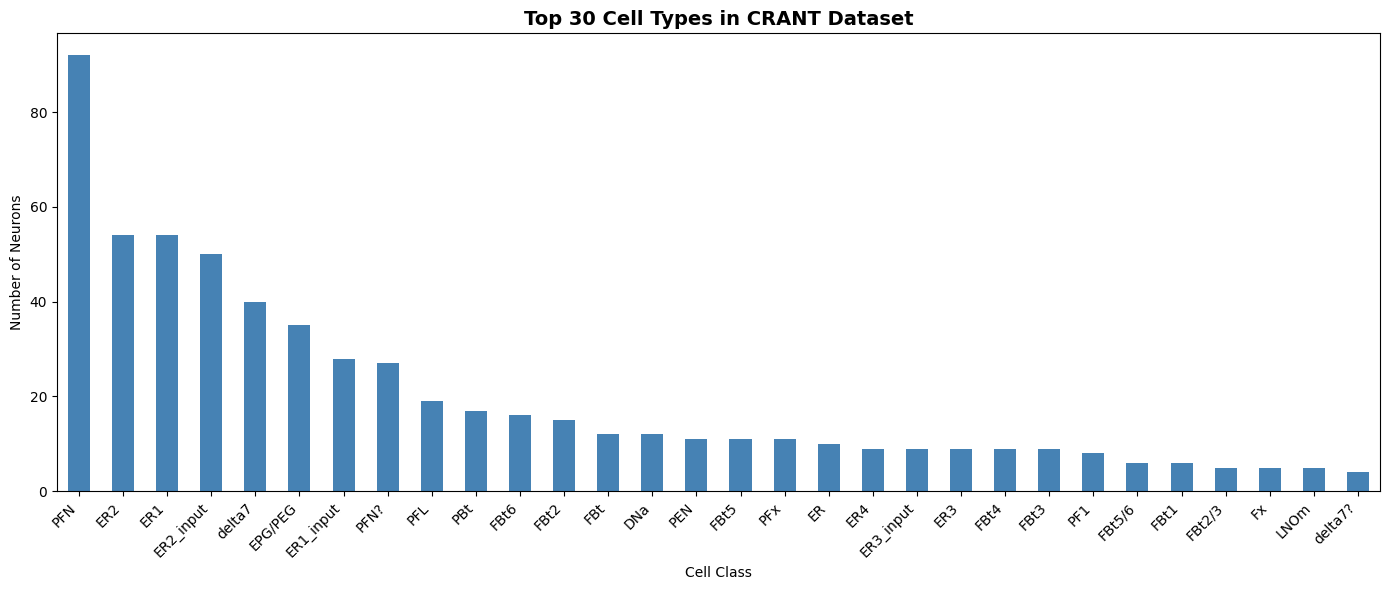

In [5]:
# Explore the distribution of cell types
cell_type_counts = all_annotations['cell_type'].value_counts()
print("Top 30 annotated cell types:")
print(cell_type_counts.head(30))

# Visualize
plt.figure(figsize=(14, 6))
cell_type_counts.head(30).plot(kind='bar', color='steelblue')
plt.title('Top 30 Cell Types in CRANT Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Cell Class')
plt.ylabel('Number of Neurons')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Basic Querying with NeuronCriteria

The `NeuronCriteria` class is the main interface for filtering neurons. Let's start with simple queries.

### Simple Single-Criterion Queries

The most basic query is filtering by a single field.

In [7]:
# Query neurons by cell class
olfactory_projection_neurons = cp.NeuronCriteria(cell_class='olfactory_projection_neuron')
opn_ids = olfactory_projection_neurons.get_roots()
print(f"Found {len(opn_ids)} olfactory projection neurons")

# Query neurons by side
left_neurons = cp.NeuronCriteria(side='left')
left_ids = left_neurons.get_roots()
print(f"Found {len(left_ids)} left-side neurons")

# Query neurons by tract
malt_neurons = cp.NeuronCriteria(tract='mALT')
malt_ids = malt_neurons.get_roots()
print(f"Found {len(malt_ids)} neurons in mALT tract")

Found 107 olfactory projection neurons
Found 3648 left-side neurons
Found 2275 neurons in mALT tract


### Multi-Criterion Queries (Logical AND)

You can combine multiple criteria - the query will return neurons matching **all** criteria (logical AND).

In [8]:
# Combine cell class and side
left_opn = cp.NeuronCriteria(
    cell_class='olfactory_projection_neuron',
    side='left'
)
left_opn_ids = left_opn.get_roots()
print(f"Found {len(left_opn_ids)} left olfactory projection neurons")

# Combine region, side, and proofread status
mb_left_proofread = cp.NeuronCriteria(
    region='MB',
    side='left',
    proofread=True
)
mb_left_proofread_ids = mb_left_proofread.get_roots()
print(f"Found {len(mb_left_proofread_ids)} proofread left mushroom body neurons")

Found 37 left olfactory projection neurons
Found 30 proofread left mushroom body neurons


## 4. Advanced Filtering Options

CRANTpy offers powerful filtering options for complex queries.

### Using Regular Expressions

Regular expressions (`regex=True`) enable powerful pattern matching for finding related groups of neurons.

In [9]:
# Find all ExR subtypes using regex
ExR_subtypes = cp.NeuronCriteria(
    cell_type='ExR',  # Matches ExR_a, ExR_b, etc.
    regex=True
)
ExR_subtype_ids = ExR_subtypes.get_roots()
print(f"Found {len(ExR_subtype_ids)} ExR subtype neurons")

# Get their annotations to see the specific types
exR_annotations = cp.get_annotations(ExR_subtypes)
print("\nExR subtypes found:")
print(exR_annotations['cell_type'].value_counts())

# More complex regex: Find all tangential neurons (FBt or PBt)
all_tangential = cp.NeuronCriteria(
    cell_type='[FBt|PBt]',  # Matches FBt or PBt
    regex=True
)
all_tangential_ids = all_tangential.get_roots()
print(f"\nFound {len(all_tangential_ids)} tangential neurons (FBt/PBt)")

Found 6 ExR subtype neurons


2025-10-10 07:58:43 - WARNING - Failed to update 2 annotation root ID(s). These IDs may no longer exist.



ExR subtypes found:
cell_type
ExR1    4
ExR2    2
Name: count, dtype: int64

Found 450 tangential neurons (FBt/PBt)


### Filtering with Lists: `match_all` Parameter

When filtering by a list of values on fields that contain lists (like `status` or `region`), the `match_all` parameter controls the matching behavior.

In [10]:
# match_all=False (default): neurons with ANY of the specified statuses
any_status = cp.NeuronCriteria(
    status=['BACKBONE_PROOFREAD', 'PRELIM_PROOFREAD'],
    match_all=False  # This is the default
)
any_status_ids = any_status.get_roots()
print(f"Neurons with ANY of the specified statuses: {len(any_status_ids)}")

# match_all=True: neurons with ALL of the specified statuses
all_statuses = cp.NeuronCriteria(
    status=['DAMAGED', 'TRACING_ISSUE'],
    match_all=True
)
try:
    all_statuses_ids = all_statuses.get_roots()
    print(f"Neurons with ALL of the specified statuses: {len(all_statuses_ids)}")
except Exception as e:
    print(f"Query returned: {e}")

# Practical example: neurons in multiple regions
multi_region = cp.NeuronCriteria(
    region=['MB', 'AL'],  # Neurons that innervate both regions
    match_all=True
)
try:
    multi_region_ids = multi_region.get_roots()
    print(f"\nNeurons in BOTH MB and AL: {len(multi_region_ids)}")
except Exception as e:
    print(f"\nQuery returned: {e}")

Neurons with ANY of the specified statuses: 715
Neurons with ALL of the specified statuses: 2

Neurons in BOTH MB and AL: 128


### Substring Matching: `exact` Parameter

By default, queries match values exactly. Setting `exact=False` enables substring matching.

In [11]:
# exact=True (default): exact matching only
exact_match = cp.NeuronCriteria(
    cell_class='olfactory_projection_neuron',
    exact=True
)
exact_ids = exact_match.get_roots()
print(f"Exact match for 'olfactory_projection_neuron': {len(exact_ids)}")

# exact=False: substring matching
substring_match = cp.NeuronCriteria(
    cell_class='projection',  # Will match any cell_class containing 'projection'
    exact=False
)
substring_ids = substring_match.get_roots()
print(f"Substring match for 'projection': {len(substring_ids)}")

# See what was matched
substring_annotations = cp.get_annotations(substring_match)
print("\nCell classes matched (substring 'projection'):")
print(substring_annotations['cell_class'].value_counts())

Exact match for 'olfactory_projection_neuron': 107
Substring match for 'projection': 107

Cell classes matched (substring 'projection'):
cell_class
olfactory_projection_neuron    109
spiny_kenyon_cell                1
Name: count, dtype: int64

Cell classes matched (substring 'projection'):
cell_class
olfactory_projection_neuron    109
spiny_kenyon_cell                1
Name: count, dtype: int64


### Case-Sensitive Matching

By default, string matching is case-insensitive. Use `case=True` for case-sensitive matching (only applies when `regex=True`).

In [12]:
# Case-insensitive (default)
case_insensitive = cp.NeuronCriteria(
    cell_type='exr',  # Will match ExR, exr, ExR_a, etc.
    regex=True,
    case=False  # This is the default
)
case_insensitive_ids = case_insensitive.get_roots()
print(f"Case-insensitive match for 'exr': {len(case_insensitive_ids)}")

# Case-sensitive
case_sensitive = cp.NeuronCriteria(
    cell_type='exr',  # Will only match exact case
    regex=True,
    case=True
)
try:
    case_sensitive_ids = case_sensitive.get_roots()
    print(f"Case-sensitive match for 'exr': {len(case_sensitive_ids)}")
except Exception as e:
    print(f"Case-sensitive match returned: {e}")

Case-insensitive match for 'exr': 6
Case-sensitive match returned: No neurons found matching the given criteria.


## 5. Working with Annotations

Beyond just getting root IDs, you can fetch full annotation data for neurons.

In [13]:
# Get annotations for a NeuronCriteria object
mb_neurons = cp.NeuronCriteria(region='MB')
mb_annotations = cp.get_annotations(mb_neurons)

print(f"Retrieved annotations for {len(mb_annotations)} MB neurons")
print(f"\nColumns available: {list(mb_annotations.columns)}")
print("\nFirst few rows:")
display(mb_annotations[['root_id', 'cell_class', 'cell_type', 'side', 'region']].head())

# Get annotations for specific root IDs
sample_ids = opn_ids[:5]
sample_annotations = cp.get_annotations(sample_ids)
print(f"\nAnnotations for {len(sample_annotations)} specific neurons:")
display(sample_annotations[['root_id', 'cell_class', 'cell_type', 'tract']])

Retrieved annotations for 323 MB neurons

Columns available: ['root_id', 'root_id_processed', 'supervoxel_id', 'position', 'nucleus_id', 'nucleus_position', 'root_position', 'cave_table', 'proofread', 'status', 'region', 'proofreader_notes', 'side', 'nerve', 'tract', 'hemilineage', 'flow', 'super_class', 'cell_class', 'cell_type', 'cell_subtype', 'cell_instance', 'known_nt', 'known_nt_source', 'alternative_names', 'annotator_notes', 'user_annotator', 'user_proofreader', 'ngl_link', 'date_proofread']

First few rows:


,root_id,cell_class,cell_type,side,region
0,576460752700282748,olfactory_projection_neuron,None,left,"[LH, AL, MB]"
1,576460752681552812,olfactory_projection_neuron,None,left,"[LH, AL, MB]"
2,576460752666303418,spiny_kenyon_cell,None,right,[MB]
3,576460752722405178,olfactory_projection_neuron,None,left,"[LH, AL, MB]"
4,576460752773799604,olfactory_projection_neuron,None,right,"[LH, AL, MB]"



Annotations for 10 specific neurons:


,root_id,cell_class,cell_type,tract
0,576460752700282748,olfactory_projection_neuron,None,mALT
1,576460752681552812,olfactory_projection_neuron,None,mALT
2,576460752722405178,olfactory_projection_neuron,None,mALT
3,576460752773799604,olfactory_projection_neuron,None,mALT
4,576460752656800770,olfactory_projection_neuron,None,lALT
5,576460752722405178,spiny_kenyon_cell,None,None
6,576460752681552812,None,None,mALT
7,576460752722405178,None,None,mALT
8,576460752773799604,None,None,mALT
9,576460752700282748,None,None,mALT


### Automatic ID Updating

CRANTpy automatically handles segmentation edits through the `update_ids` parameter. When neurons are edited in the segmentation, their root IDs change. This can cause mismatches between your query IDs and annotation IDs.

In [16]:
# By default, both NeuronCriteria and get_annotations update IDs automatically

# Example 1: NeuronCriteria automatically updates returned IDs
nc = cp.NeuronCriteria(cell_class='olfactory_projection_neuron')
current_ids = nc.get_roots()  # These are the latest root IDs
print(f"NeuronCriteria returned {len(current_ids)} neurons with updated IDs")

# Example 2: get_annotations updates annotation IDs before matching
# This ensures that even if you have a newer root ID, it will match
# against the updated annotation IDs
sample_id = int(current_ids[0])  # Convert numpy int64 to Python int
annotations = cp.get_annotations(sample_id)  # update_ids=True by default
print(f"\nSuccessfully retrieved annotations for ID {sample_id}")
print(f"Cell class: {annotations.iloc[0]['cell_class']}")

# You can disable automatic updating if needed
nc_no_update = cp.NeuronCriteria(cell_class='olfactory_projection_neuron', update_ids=False)
old_style_ids = nc_no_update.get_roots()  # IDs as stored in annotations
print(f"\nWithout update_ids: {len(old_style_ids)} neurons")

# Similarly for get_annotations
annotations_no_update = cp.get_annotations(sample_id, update_ids=False)
print(f"Annotations retrieved without ID updating")

NeuronCriteria returned 107 neurons with updated IDs

Successfully retrieved annotations for ID 576460752700282748
Cell class: olfactory_projection_neuron

Without update_ids: 107 neurons
Annotations retrieved without ID updating


**Why is this important?**

When the segmentation is edited (e.g., neurons are merged or split), root IDs change. Without automatic updating:
- Your queries might use outdated IDs that no longer exist
- Annotations might contain old IDs that don't match your current data
- You'd need to manually track and update IDs

With automatic updating enabled (the default):
- `NeuronCriteria.get_roots()` returns the latest root IDs
- `get_annotations()` updates annotation IDs before matching
- Everything stays synchronized automatically
- Per-ID caching makes this efficient

## 6. Checking Proofread Status

You can quickly check which neurons are proofread using the `is_proofread` function.

In [17]:
# Check proofread status for a list of neurons
sample_ids = opn_ids[:10]
proofread_status = cp.is_proofread(sample_ids)

print(f"Checking proofread status for {len(sample_ids)} neurons:")
for neuron_id, is_pr in zip(sample_ids, proofread_status):
    status = "✓ Proofread" if is_pr else "✗ Not proofread"
    print(f"  {neuron_id}: {status}")

print(f"\nSummary: {np.sum(proofread_status)}/{len(proofread_status)} are proofread")

# You can also check using NeuronCriteria
proofread_status_criteria = cp.is_proofread(olfactory_projection_neurons)
print(f"\nOf all {len(olfactory_projection_neurons)} OPNs, {np.sum(proofread_status_criteria)} are proofread")

Checking proofread status for 10 neurons:
  576460752700282748: ✗ Not proofread
  576460752681552812: ✓ Proofread
  576460752722405178: ✗ Not proofread
  576460752773799604: ✓ Proofread
  576460752656800770: ✓ Proofread
  576460752722298426: ✗ Not proofread
  576460752768215072: ✗ Not proofread
  576460752680204173: ✓ Proofread
  576460752728003009: ✓ Proofread
  576460752780951210: ✗ Not proofread

Summary: 5/10 are proofread

Of all 107 OPNs, 65 are proofread


## 7. NeuronCriteria as Iterable and Container

`NeuronCriteria` objects support Python's iterator and container protocols, making them very convenient to use.

In [18]:
# Get length
print(f"Number of OPNs: {len(olfactory_projection_neurons)}")

# Iterate over root IDs
print("\nFirst 5 OPN root IDs (using iteration):")
for i, root_id in enumerate(olfactory_projection_neurons):
    if i >= 5:
        break
    print(f"  {root_id}")

# Check membership
sample_id = opn_ids[0]
is_member = sample_id in olfactory_projection_neurons
print(f"\nIs {sample_id} an OPN? {is_member}")

# Check a neuron that's not an OPN
non_opn_id = left_ids[0]  # A random left neuron
is_member = non_opn_id in olfactory_projection_neurons
print(f"Is {non_opn_id} an OPN? {is_member}")

Number of OPNs: 107

First 5 OPN root IDs (using iteration):
  576460752700282748
  576460752681552812
  576460752722405178
  576460752773799604
  576460752656800770

Is 576460752700282748 an OPN? True
Is 576460752700282748 an OPN? True


## 8. Performance and Caching

CRANTpy caches annotation data to improve performance. You can control this behavior.

In [19]:
import time

# First query - may take longer (fetching from Seatable)
start = time.time()
query1 = cp.NeuronCriteria(cell_class='olfactory_projection_neuron', clear_cache=True)
ids1 = query1.get_roots()
time1 = time.time() - start
print(f"First query (no cache): {time1:.3f} seconds")

# Second query - should be faster (using cached data)
start = time.time()
query2 = cp.NeuronCriteria(cell_class='olfactory_projection_neuron')
ids2 = query2.get_roots()
time2 = time.time() - start
print(f"Second query (cached): {time2:.3f} seconds")

# Force refresh from Seatable
start = time.time()
query3 = cp.NeuronCriteria(cell_class='olfactory_projection_neuron', clear_cache=True)
ids3 = query3.get_roots()
time3 = time.time() - start
print(f"Query with cache refresh: {time3:.3f} seconds")

First query (no cache): 2.984 seconds
Second query (cached): 0.006 seconds
Query with cache refresh: 1.749 seconds
Query with cache refresh: 1.749 seconds


## 9. Analyzing Query Results

Once you have a set of neurons, you can perform various analyses on their annotations.

Found 3 tracts: ['mALT', 'lALT', 'mlALT']...


2025-10-10 08:02:04 - WARNING - Failed to update 2 annotation root ID(s). These IDs may no longer exist.



Tract analysis:


,tract,n_neurons,n_cell_classes,n_cell_types,n_proofread,pct_proofread
0,mALT,2275,4,0,41,1.8%
1,lALT,227,2,0,29,12.8%
2,mlALT,235,3,0,3,1.3%


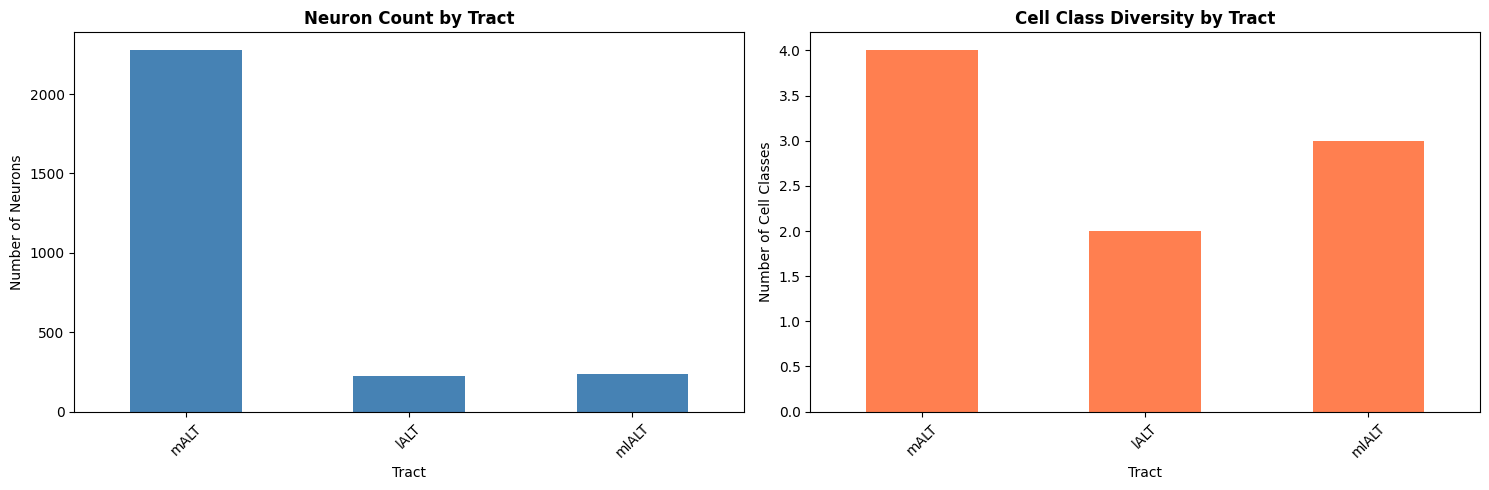

In [20]:
# Analyze connectivity patterns by tract
tracts = all_annotations['tract'].dropna().unique()
print(f"Found {len(tracts)} tracts: {list(tracts)[:10]}...")  # Show first 10

# Analyze each tract
tract_analysis = []
for tract in tracts[:8]:  # Analyze first 8 tracts for demonstration
    tract_neurons = cp.NeuronCriteria(tract=tract)
    tract_ids = tract_neurons.get_roots()
    tract_annotations = cp.get_annotations(tract_neurons)
    
    # Count unique cell classes
    n_cell_classes = len(tract_annotations['cell_class'].unique())
    n_cell_types = len(tract_annotations['cell_type'].dropna().unique())
    
    # Count proofread neurons
    n_proofread = tract_annotations['proofread'].sum() if 'proofread' in tract_annotations.columns else 0
    
    tract_analysis.append({
        'tract': tract,
        'n_neurons': len(tract_ids),
        'n_cell_classes': n_cell_classes,
        'n_cell_types': n_cell_types,
        'n_proofread': n_proofread,
        'pct_proofread': f"{100 * n_proofread / len(tract_ids):.1f}%"
    })

tract_df = pd.DataFrame(tract_analysis)
print("\nTract analysis:")
display(tract_df)

# Visualize tract composition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

tract_df.plot(x='tract', y='n_neurons', kind='bar', ax=ax1, color='steelblue', legend=False)
ax1.set_title('Neuron Count by Tract', fontsize=12, fontweight='bold')
ax1.set_xlabel('Tract')
ax1.set_ylabel('Number of Neurons')
ax1.tick_params(axis='x', rotation=45)

tract_df.plot(x='tract', y='n_cell_classes', kind='bar', ax=ax2, color='coral', legend=False)
ax2.set_title('Cell Class Diversity by Tract', fontsize=12, fontweight='bold')
ax2.set_xlabel('Tract')
ax2.set_ylabel('Number of Cell Classes')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Cross-Analysis: Comparing Populations

Left side: 3792 neurons
Right side: 1897 neurons

Top 5 cell classes on left:
cell_class
descending_neuron              96
ER                             76
FBc                            64
olfactory_projection_neuron    63
FBt                            52
Name: count, dtype: int64

Top 5 cell classes on right:
cell_class
FBc                            102
olfactory_projection_neuron     79
ER                              60
spiny_kenyon_cell               38
photo_receptor                  38
Name: count, dtype: int64


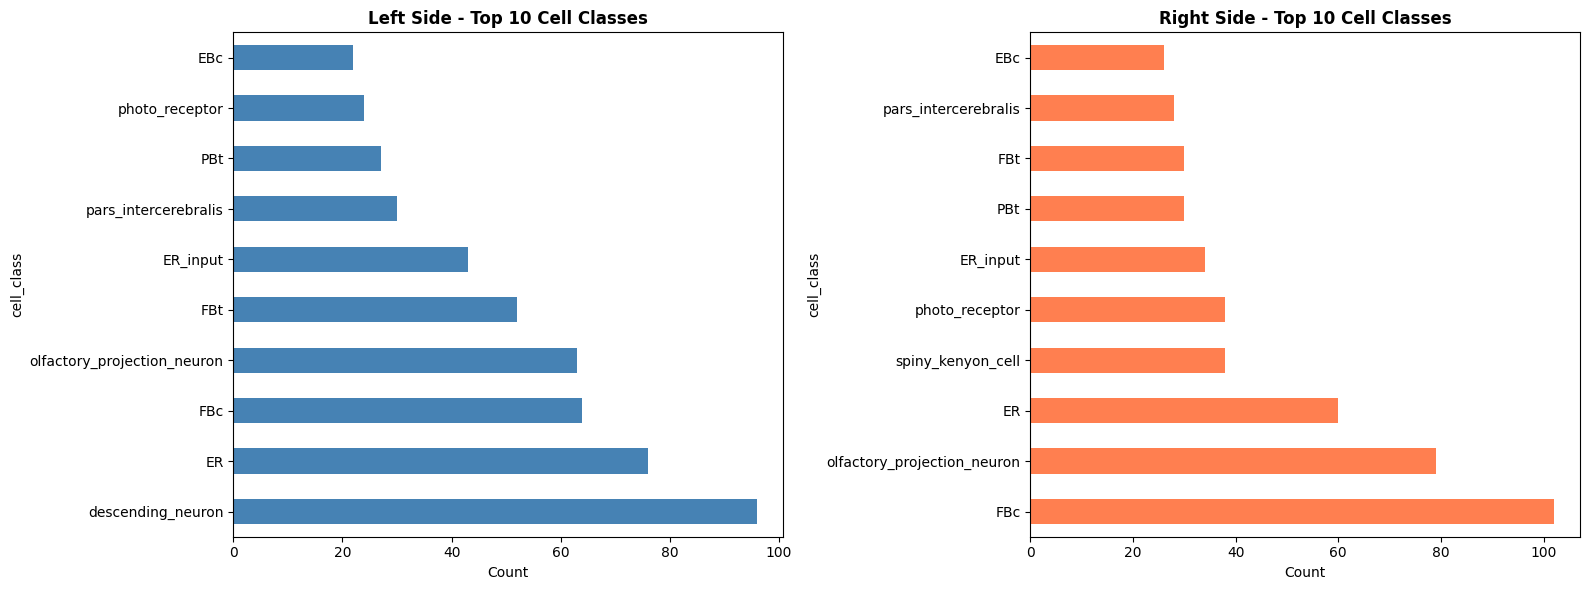

In [21]:
# Compare left vs right neurons
left_neurons = cp.NeuronCriteria(side='left')
right_neurons = cp.NeuronCriteria(side='right')

left_ann = cp.get_annotations(left_neurons)
right_ann = cp.get_annotations(right_neurons)

print(f"Left side: {len(left_ann)} neurons")
print(f"Right side: {len(right_ann)} neurons")

# Compare cell class distribution
print("\nTop 5 cell classes on left:")
print(left_ann['cell_class'].value_counts().head())

print("\nTop 5 cell classes on right:")
print(right_ann['cell_class'].value_counts().head())

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

left_ann['cell_class'].value_counts().head(10).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Left Side - Top 10 Cell Classes', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')

right_ann['cell_class'].value_counts().head(10).plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Right Side - Top 10 Cell Classes', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

## 10. Best Practices and Tips

Here are some best practices for effective querying with CRANTpy.

### 1. Start Broad, Then Refine

Begin with broad queries and progressively add criteria to narrow down your results.

In [22]:
# Step 1: Broad query
step1 = cp.NeuronCriteria(region='CX')
print(f"Step 1 - All CX neurons: {len(step1)}")

# Step 2: Add side constraint
step2 = cp.NeuronCriteria(region='CX', side='left')
print(f"Step 2 - Left CX neurons: {len(step2)}")

# Step 3: Add cell class
step3 = cp.NeuronCriteria(region='CX', side='left', cell_class='ER')
print(f"Step 3 - Left CX ER neurons: {len(step3)}")

# Step 4: Add proofread constraint
step4 = cp.NeuronCriteria(region='CX', side='left', cell_class='ER', proofread=True)
print(f"Step 4 - Proofread left CX ER neurons: {len(step4)}")

Step 1 - All CX neurons: 656
Step 2 - Left CX neurons: 298
Step 3 - Left CX ER neurons: 70
Step 4 - Proofread left CX ER neurons: 59


### 2. Use `verbose=True` for Debugging

Enable verbose mode to see what's happening during queries.

In [23]:
cp.set_logging_level("DEBUG") # this needs to be updated to see messages

# Without verbose (default)
query_quiet = cp.NeuronCriteria(cell_class='olfactory_projection_neuron', side='left')
ids_quiet = query_quiet.get_roots()

# With verbose
query_verbose = cp.NeuronCriteria(
    cell_class='olfactory_projection_neuron',
    side='left',
    verbose=True
)
ids_verbose = query_verbose.get_roots()

cp.set_logging_level("WARNING")

2025-10-10 08:02:05 - DEBUG - Generated cache key: latest for seatable_annotations
2025-10-10 08:02:05 - DEBUG - Cache hit for seatable_annotations with key: latest
2025-10-10 08:02:05 - DEBUG - Using cached seatable_annotations.
2025-10-10 08:02:05 - DEBUG - update_ids_cache: 37 cached, 0 uncached
2025-10-10 08:02:05 - DEBUG - Using fully cached results from update_ids_cache
2025-10-10 08:02:05 - DEBUG - Cache hit for seatable_annotations with key: latest
2025-10-10 08:02:05 - DEBUG - Using cached seatable_annotations.
2025-10-10 08:02:05 - DEBUG - update_ids_cache: 37 cached, 0 uncached
2025-10-10 08:02:05 - DEBUG - Using fully cached results from update_ids_cache
2025-10-10 08:02:05 - DEBUG - Generated cache key: latest for seatable_annotations
2025-10-10 08:02:05 - DEBUG - Cache hit for seatable_annotations with key: latest
2025-10-10 08:02:05 - DEBUG - Using cached seatable_annotations.
2025-10-10 08:02:05 - INFO - Found 37 neurons matching the given criteria.
2025-10-10 08:02:05 

### 3. Inspect Available Values Before Querying

Check what values exist in your fields of interest before building queries.

In [24]:
# Check what tracts are available
print("Available tracts:")
print(all_annotations['tract'].dropna().unique())

# Check what statuses exist
print("\nAvailable statuses (flatten lists):")
status_lists = all_annotations['status'].dropna().tolist()
flat_statuses = set([status for sublist in status_lists for status in (sublist if isinstance(sublist, list) else [sublist])])
print(flat_statuses)

# Check cell types for a specific cell class
fbt_neurons_check = cp.NeuronCriteria(cell_class='FBt')
fbt_ann_check = cp.get_annotations(fbt_neurons_check)
print("\nCell types for mushroom_body_intrinsic_neuron:")
print(fbt_ann_check['cell_type'].value_counts())

Available tracts:
['mALT' 'lALT' 'mlALT']

Available statuses (flatten lists):
{'MISSING_SOMA', 'empty', 'NA', 'MERGE_ERROR', 'MERGE_MONSTER', 'DUPLICATED', 'TO_PROOFREAD', 'BACKBONE_PROOFREAD', 'PARTIALLY_PROOFREAD', 'DAMAGED', 'TRACING_ISSUE', 'THOROUGHLY_PROOFREAD'}

Cell types for mushroom_body_intrinsic_neuron:
cell_type
FBt6      16
FBt2      15
FBt       12
FBt5      11
FBt4       9
FBt3       9
FBt1       6
FBt5/6     6
FBt2/3     5
FBt1/2     2
Name: count, dtype: int64


## Summary

In this comprehensive deep dive, you learned:

✅ **NeuronCriteria fundamentals** - Basic and multi-criterion queries  
✅ **Advanced filtering options** - `regex`, `match_all`, `exact`, `case` parameters  
✅ **Working with annotations** - Fetching and analyzing neuron metadata  
✅ **Proofread status checking** - Identifying which neurons are proofread  
✅ **Iterator/container protocols** - Using NeuronCriteria as iterable objects  
✅ **Performance optimization** - Understanding and controlling caching behavior  
✅ **Population analysis** - Comparing and analyzing query results  
✅ **Best practices** - Strategies for efficient and effective querying  

### Key Takeaways

1. **Combine criteria**: Use multiple parameters to precisely target neuron populations
2. **Leverage regex**: Pattern matching is powerful for finding related neuron groups
3. **Understand match_all**: Control how lists are matched (ANY vs ALL)
4. **Inspect first**: Always explore available data before building complex queries
5. **Use annotations**: Don't just get IDs - analyze the full metadata